In [1]:
from therapy.query import QueryHandler
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

q = QueryHandler()
conn = psycopg2.connect("dbname=dgidb")

***Using Therapy Database Endpoint: http://localhost:8000***


### Tables to create

* histogram of # of claims per drug
* see if ^^ changes after new normalization routine
* nonnormalizable drugs
* nonnormalizeble drugs by source
* nonnormalizable claims
* nonnormalizable claims by source

# Look at previously un-grouped terms

In [2]:
# previously non-normalized terms
cur = conn.cursor()
cur.execute("""
SELECT d.name, d.nomenclature, d.primary_name, s.full_name
FROM   drug_claims d
LEFT JOIN sources s ON d.source_id = s.id
WHERE d.drug_id IS NULL;
""")
old_unnormalized_drugs = cur.fetchall()
cur.close()

total = 0
by_source = {}
normalized = 0
for drug_claim in old_unnormalized_drugs:
    total += 1
    if q.normalize(drug_claim[0]).match_type > 0:
        normalized += 1
        if drug_claim [3] in by_source:
            by_source[drug_claim[3]]["normalized"] += 1
        else:
            by_source[drug_claim[3]] = {
                "normalized": 1,
                "failed": 0
            }
    elif q.normalize(drug_claim[2]).match_type > 0:
        normalized += 1
        if drug_claim [3] in by_source:
            by_source[drug_claim[3]]["normalized"] += 1
        else:
            by_source[drug_claim[3]] = {
                "normalized": 1,
                "failed": 0
            }
    else:
        if drug_claim [3] in by_source:
            by_source[drug_claim[3]]["failed"] += 1
        else:
            by_source[drug_claim[3]] = {
                "normalized": 0,
                "failed": 1
            }

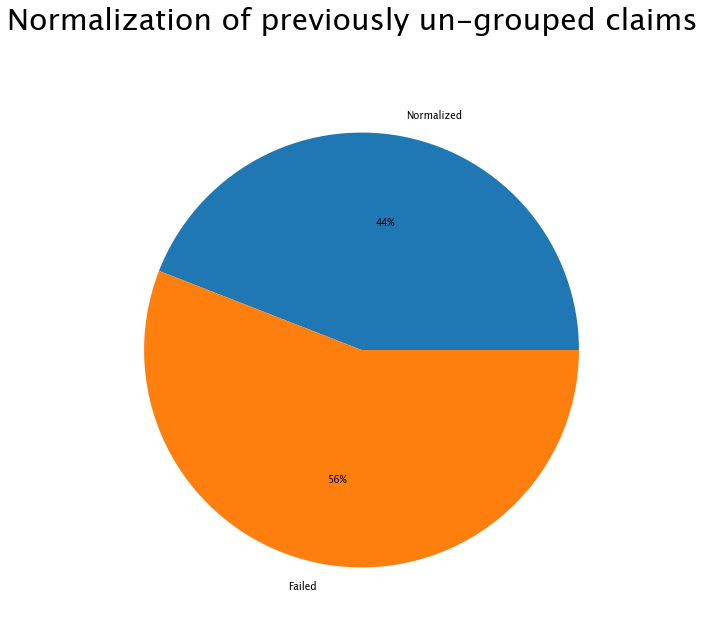

In [3]:
colors = sns.color_palette('pastel')[0:2]
plt.rcParams["figure.figsize"] = (10,10)
fig, ax = plt.subplots()
ax.pie([(normalized/total), (1 - (normalized/total))], labels=["Normalized", "Failed"], autopct='%.0f%%')
f = fig.suptitle("Normalization of previously un-grouped claims", fontsize=30)

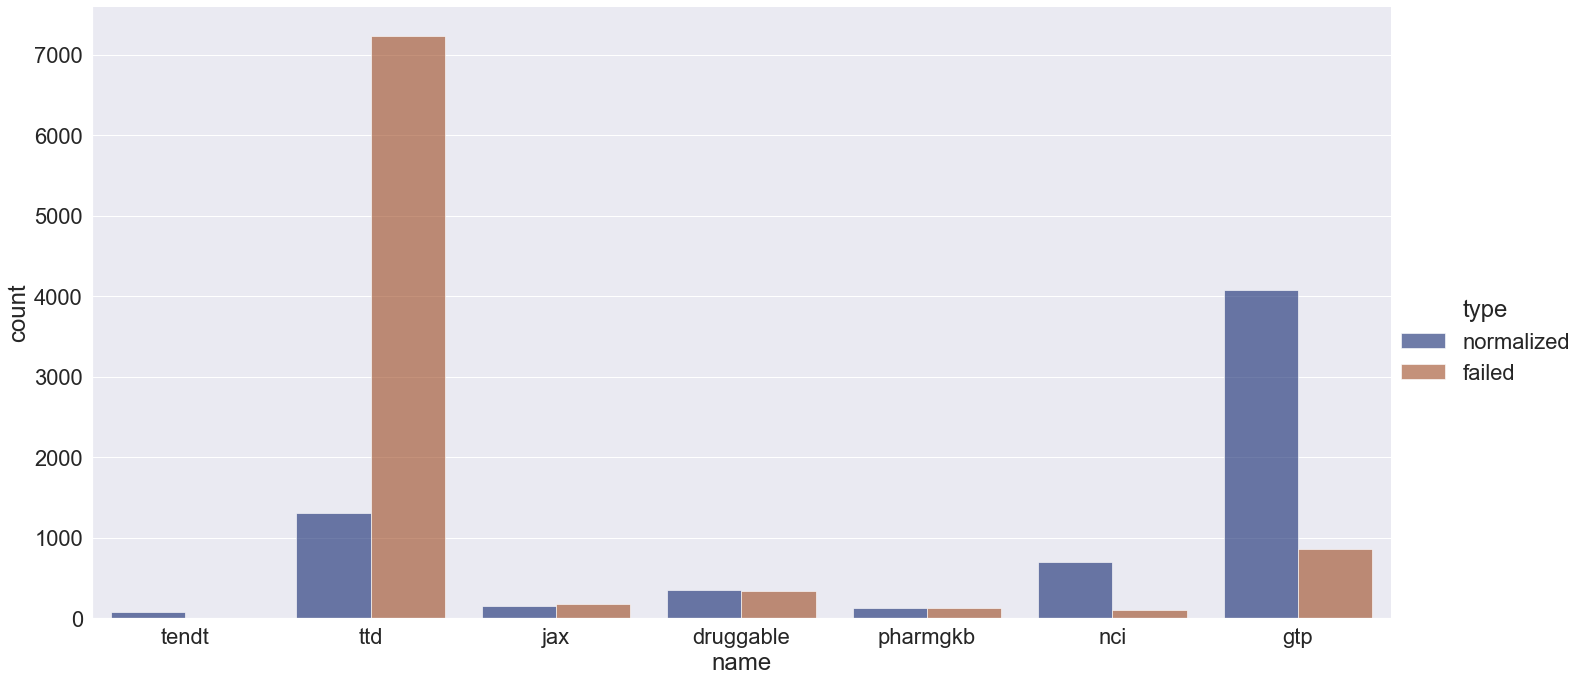

In [4]:
sns.set_theme(style="whitegrid")
norm_df_in = [[name, 'normalized', v['normalized']] for name, v in by_source.items()]
failed_df_in = [[name, 'failed', v['failed']] for name, v in by_source.items()]

sources_df = pd.DataFrame(norm_df_in + failed_df_in, columns=["name", "type", "count"]).sort_values(by=["name", "type"], ascending=False).replace({
    "CIViC: Clinical Interpretation of Variants in Cancer": "civic",
    "Catalogue Of Somatic Mutations In Cancer": "cosmic",
    "Clearity Foundation Biomarkers": "clearity biomarkers",
    "Clearity Foundation Clinical Trial": "clearity trials",
    "Database of Curated Mutations": "dcm",
    "Drug Target Commons": "dtc",
    "FDA Pharmacogenomic Biomarkers": "fda",
    "Guide to Pharmacology": "gtp",
    "MyCancerGenome Clinical Trial": "mcg trial",
    "My Cancer Genome": "mcg",
    "NCI Cancer Gene Index": "nci",
    "OncoKB: A Precision Oncology Knowledge Base": "oncokb",
    "PharmGKB - The Pharmacogenomics Knowledgebase": "pharmgkb",
    "Targeted Agents in Lung Cancer (Commentary, 2014)": "talc",
    "The ChEMBL Bioactivity Database": "chembl",
    'The Druggable Genome: Evaluation of Drug Targets in Clinical Trials Suggests Major Shifts in Molecular Class and Indication (Rask-Andersen, Masuram, Schioth 2014)': "druggable",
    'The Jackson Laboratory Clinical Knowledgebase': 'jax',
    'Therapeutic Target Database': "ttd",
    'Trends in the exploitation of novel drug targets (Rask-Andersen, et al., 2011)': 'tendt'
})
big_sources = ["gfp", "nci", "pharmgkb", "druggable", "jax", "ttd", "tendt", "gtp"]
sources_df_big = sources_df[sources_df["name"].isin(big_sources)]
sns.set(font_scale=2)
p = sns.catplot(data=sources_df_big, kind="bar", x="name", y="count", hue="type", ci="sd", 
                palette="dark", alpha=.6, height=10, aspect=2)

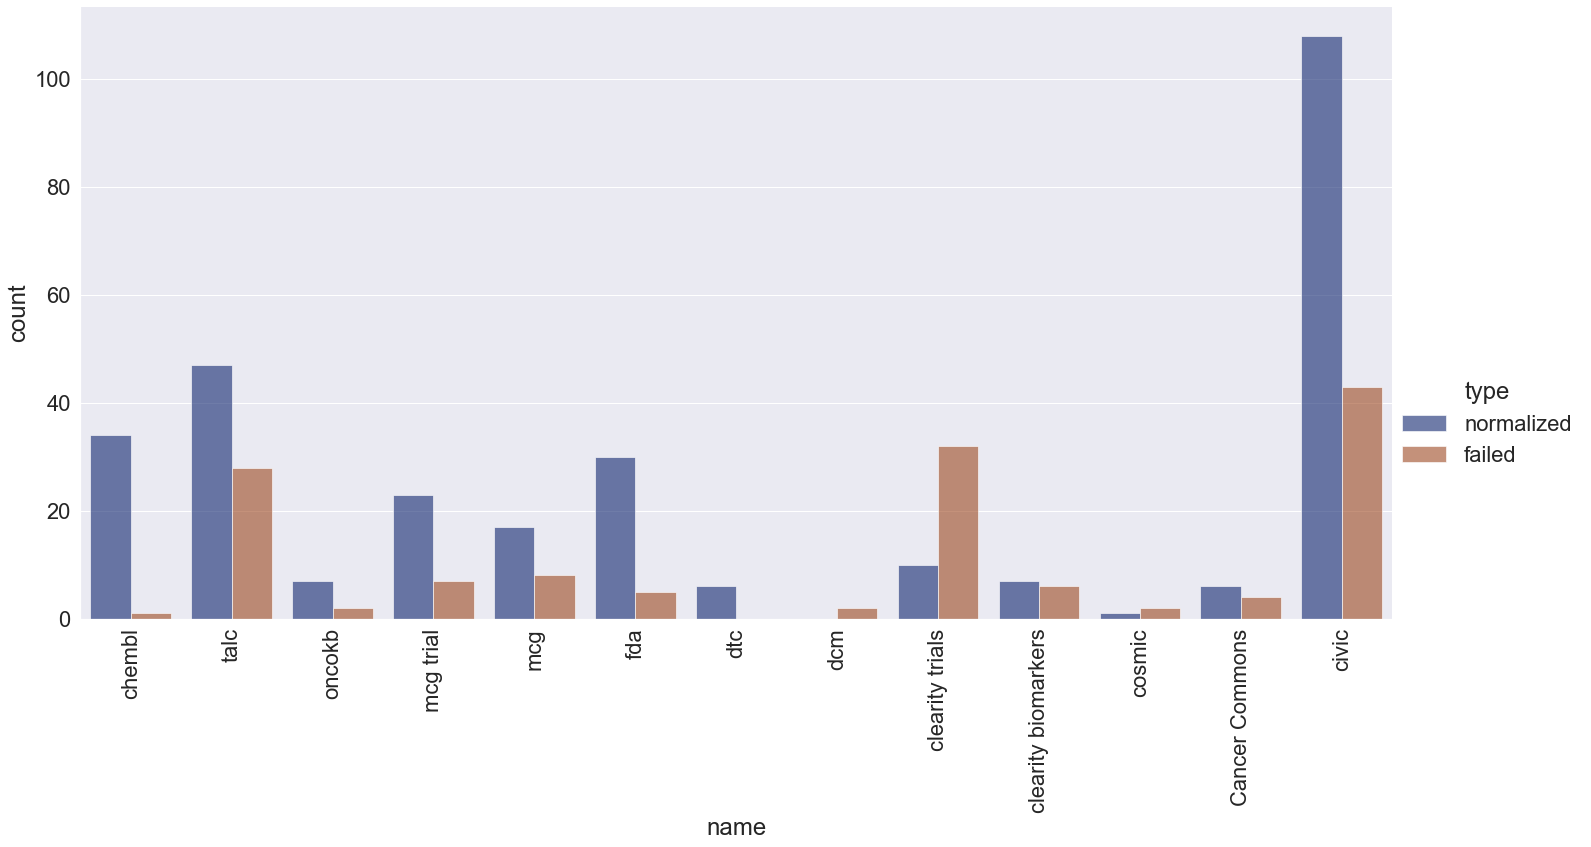

In [5]:
sources_df_small = sources_df[~sources_df["name"].isin(big_sources)]
p = sns.catplot(data=sources_df_small, kind="bar", x="name", y="count", hue="type", ci="sd", 
                palette="dark", alpha=.6, height=10, aspect=2)
p.set_xticklabels(rotation=90)

In [6]:
# check gtp fails

cur = conn.cursor()
cur.execute("""
SELECT 
    dc.name AS claim_name, 
    dc.nomenclature AS claim_name_nomenclature, 
    dc.primary_name AS claim_primary_name, 
    s.full_name AS source, 
    d.concept_id AS grouped_id
FROM drugs d
LEFT JOIN drug_claims dc ON d.id = dc.drug_id
LEFT JOIN sources s ON dc.source_id = s.id
""")
old_unnormalized_drugs = cur.fetchall()
cur.close()

for group in old_unnormalized_drugs:
    if group[3] == "Guide to Pharmacology":
        if (q.normalize(group[0]).match_type == 0) and (q.normalize(group[2]).match_type == 0):
            print((group[0], group[2]))

# Distribution of claims over previously-grouped drugs

In [7]:
cur = conn.cursor()
cur.execute("""
SELECT 
    dc.name AS claim_name, 
    dc.nomenclature AS claim_name_nomenclature, 
    dc.primary_name AS claim_primary_name, 
    s.full_name AS source, 
    d.concept_id AS grouped_id
FROM drugs d
LEFT JOIN drug_claims dc ON d.id = dc.drug_id
LEFT JOIN sources s ON dc.source_id = s.id
""")
grouped_claims = cur.fetchall()
cur.close()

groups = {}
for claim in grouped_claims:
    if not claim[4] in groups:
        groups[claim[4]] = 1
    else:
        groups[claim[4]] += 1

groups_df = pd.DataFrame([[k, v] for k, v in groups.items()], columns=["concept_id", "count"])

In [8]:
normed_groups = {}
fails = 0
for claim in grouped_claims:
    norm_response = q.normalize(claim[2])
    if norm_response.match_type > 0:
        therapy_id = norm_response.therapy_descriptor.therapy_id
        if therapy_id in normed_groups:
            normed_groups[therapy_id] += 1
        else:
            normed_groups[therapy_id] = 1
    elif claim[0] != claim[2]:
        norm_response = q.normalize(claim[0])
        if norm_response.match_type > 0:
            therapy_id = norm_response.therapy_descriptor.therapy_id
            if therapy_id in normed_groups:
                normed_groups[therapy_id] += 1
            else:
                normed_groups[therapy_id] = 1
    else:
        fails += 1
normed_groups_df = pd.DataFrame([[k, v] for k, v in normed_groups.items()], columns=["concept_id", "count"])

In [9]:
pd.DataFrame([groups_df["count"].describe(), normed_groups_df["count"].describe()], index=["dgidbv4 grouper", "therapy normalizer"])

,count,mean,std,min,25%,50%,75%,max
dgidbv4 grouper,14449.0,2.454772,1.816824,1.0,2.0,2.0,3.0,20.0
therapy normalizer,14886.0,2.378476,1.961772,1.0,1.0,2.0,2.0,25.0


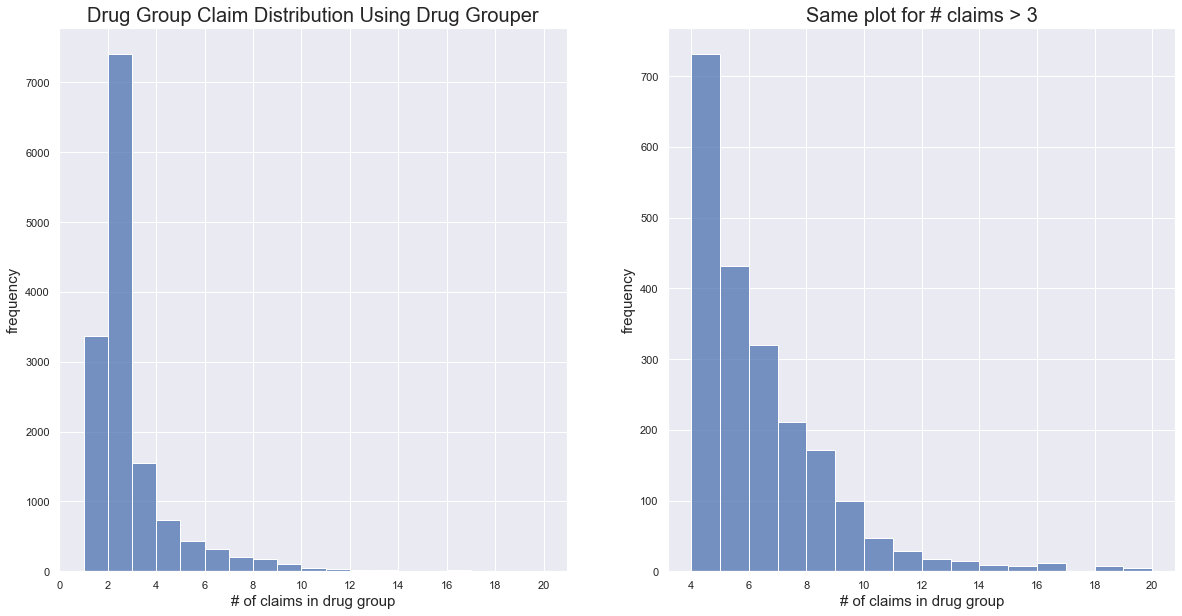

In [10]:
sns.set()
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
p = sns.histplot(groups_df, ax=ax[0], x="count", binwidth=1)
p.set_xlabel("# of claims in drug group", fontsize=15)
p.set_ylabel("frequency", fontsize=15)
p.set_title("Drug Group Claim Distribution Using Drug Grouper", fontsize=20)
ax[0].set_xticks(range(0, max(groups_df["count"]) + 1, 2))

p = sns.histplot(groups_df[groups_df["count"] > 3], ax=ax[1], x="count", binwidth=1)
p.set_xlabel("# of claims in drug group", fontsize=15)
p.set_ylabel("frequency", fontsize=15)
p.set_title("Same plot for # claims > 3", fontsize=20)
ax[1].set_xticks(range(4, max(groups_df["count"]) + 1, 2))
None

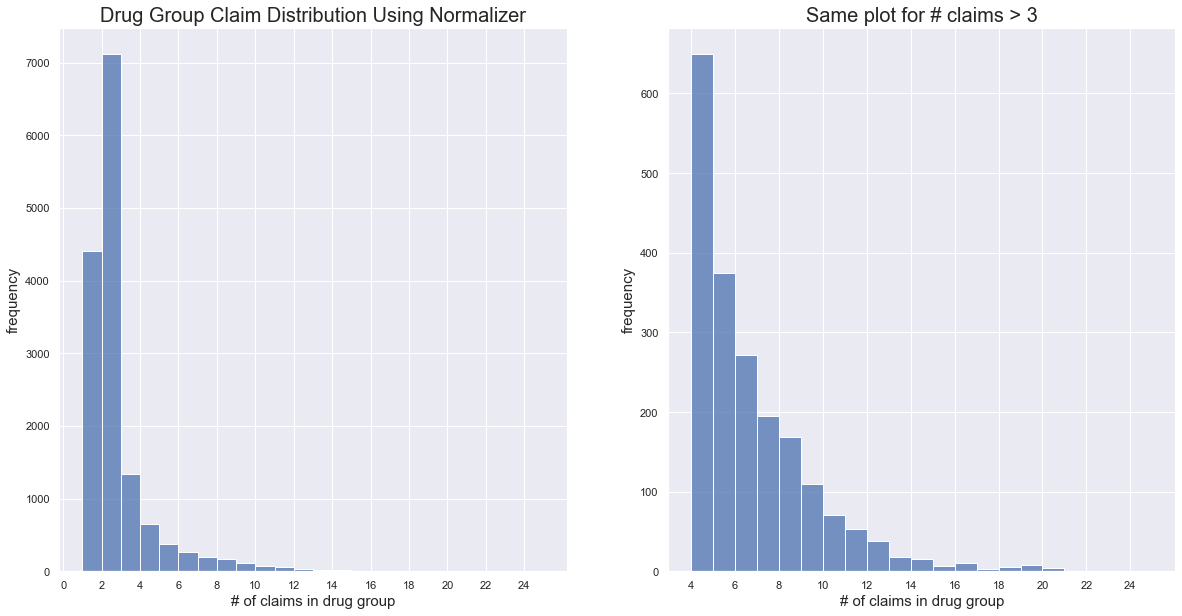

In [11]:
sns.set()
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
p = sns.histplot(normed_groups_df, ax=ax[0], x="count", binwidth=1)
p.set_xlabel("# of claims in drug group", fontsize=15)
p.set_ylabel("frequency", fontsize=15)
p.set_title("Drug Group Claim Distribution Using Normalizer", fontsize=20)
ax[0].set_xticks(range(0, max(normed_groups_df["count"]) + 1, 2))

p = sns.histplot(normed_groups_df[normed_groups_df["count"] > 3], ax=ax[1], x="count", binwidth=1)
p.set_xlabel("# of claims in drug group", fontsize=15)
p.set_ylabel("frequency", fontsize=15)
p.set_title("Same plot for # claims > 3", fontsize=20)
ax[1].set_xticks(range(4, max(normed_groups_df["count"]) + 1, 2))
None

In [12]:
# diagnostic work
check_norm_groups = {}
check_groups = {}
for claim in grouped_claims:
    if not claim[4] in check_groups:
        check_groups[claim[4]] = [claim[2].lower()]
    else:
        check_groups[claim[4]].append(claim[2].lower())
    
    norm_response = q.normalize(claim[2])
    if norm_response.match_type > 0:
        if norm_response.therapy_descriptor.therapy_id in check_norm_groups:
            check_norm_groups[norm_response.therapy_descriptor.therapy_id].append(claim[2].lower())
        else:
            check_norm_groups[norm_response.therapy_descriptor.therapy_id] = [claim[2].lower()]

In [13]:
for group in check_groups.values():
    orig_len = len(group)
    for member in set(group):
        for concept_id, normed_group in check_norm_groups.items():
            if member in normed_group and orig_len > len(normed_group):
                print(f"{member} | {orig_len} | {concept_id} | {len(normed_group)}")

lvp | 8 | iuphar.ligand:2172 | 1
carmustine | 9 | rxcui:2105 | 8
bcnu | 9 | rxcui:2105 | 8
dti-015 | 9 | ncit:C2602 | 1
amg-888 | 3 | chembl:CHEMBL2109396 | 1
nanatinostat | 4 | ncit:C78475 | 1
chr-3996 | 4 | iuphar.ligand:8391 | 3
lcl161 | 4 | iuphar.ligand:7912 | 3
lcl-161 | 4 | drugbank:DB12085 | 1
bms-536924 | 4 | iuphar.ligand:9386 | 3
chembl:chembl401930 | 4 | chembl:CHEMBL401930 | 1
bms-936559 | 3 | chembl:CHEMBL4297702 | 2
mdx-1105 | 3 | ncit:C78852 | 1
bms-908662 | 4 | drugbank:DB12854 | 1
xl-281 | 4 | chembl:CHEMBL3545027 | 2
xl281 | 4 | drugbank:DB05190 | 1
o-chloroacetylcarbamoylfumagillol | 3 | ncit:C1298 | 2
tnp-470 | 3 | drugbank:DB08633 | 1
agm-1470 | 3 | ncit:C1298 | 2
alpha interferon | 20 | ncit:C225 | 3
cetuximab | 20 | rxcui:318341 | 19
c225 | 20 | ncit:C225 | 3
leukocyte interferon | 20 | ncit:C225 | 3
tki258 | 13 | ncit:C62435 | 1
dovitinib | 13 | ncit:C76199 | 12
bedoradrine sulfate | 4 | ncit:C77933 | 2
mn-221 | 4 | chembl:CHEMBL2218893 | 2
cta018 | 4 | drugban

zalutumumab | 5 | ncit:C64620 | 4
humax-egfr | 5 | chembl:CHEMBL2107861 | 1
rilotumumab | 7 | ncit:C67079 | 6
amg-102 | 7 | chembl:CHEMBL1743063 | 1
amg 102 | 7 | ncit:C67079 | 6
radiprodil | 4 | ncit:C152143 | 3
rgh-896 | 4 | chembl:CHEMBL182066 | 1
isis-sod1rx | 4 | chembl:CHEMBL3833346 | 3
biib067 | 4 | chembl:CHEMBL3833346 | 3
tofersen | 4 | ncit:C166584 | 1
pf-06252616 | 3 | drugbank:DB15083 | 1
domagrozumab | 3 | ncit:C166800 | 2
epicatechin | 2 | drugbank:DB12039 | 1
(+)-epicatechin | 2 | chembl:CHEMBL129482 | 1
venglustat | 4 | ncit:C152852 | 2
gz402671 | 4 | drugbank:DB14966 | 2
genz-682452 | 4 | drugbank:DB14966 | 2
lmi070 | 2 | chembl:CHEMBL4290141 | 1
branaplam | 2 | ncit:C174824 | 1
shr-1314 | 2 | iuphar.ligand:9296 | 1
vunakizumab | 2 | ncit:C152923 | 1
bi655130 | 2 | chembl:CHEMBL4297911 | 1
spesolimab | 2 | ncit:C166849 | 1
gsk2140944 | 3 | drugbank:DB12134 | 1
gepotidacin | 3 | ncit:C170025 | 2
sna-120 | 3 | drugbank:DB16280 | 2
pegcantratinib | 3 | ncit:C170295 | 1
ct

l-lysine | 3 | ncit:C95739 | 1
lysine | 3 | rxcui:6536 | 2
antithrombin alfa | 2 | rxcui:1009 | 1
kw-3357 | 2 | chembl:CHEMBL1201554 | 1
ly3009120 | 5 | iuphar.ligand:8943 | 3
ly-3009120 | 5 | chembl:CHEMBL3545195 | 2
pi-88 | 5 | drugbank:DB05808 | 3
muparfostat | 5 | ncit:C38690 | 2
tmc-649128 | 2 | drugbank:DB15152 | 1
tmc649128 | 2 | chembl:CHEMBL4297499 | 1
rovatirelin | 2 | ncit:C152262 | 1
kps-0373 | 2 | chembl:CHEMBL4297622 | 1
enarodustat | 2 | ncit:C169944 | 1
jtz-951 | 2 | drugbank:DB14985 | 1
mrx-4 | 3 | iuphar.ligand:10796 | 2
contezolid acefosamil | 3 | ncit:C169864 | 1
pf-5190457 | 3 | drugbank:DB14870 | 1
pf-05190457 | 3 | iuphar.ligand:9060 | 2
modithromycin | 2 | ncit:C174586 | 1
edp-420 | 2 | chembl:CHEMBL263886 | 1
insulin-like growth factor 1 | 6 | iuphar.ligand:2495 | 1
mecasermin | 6 | rxcui:274403 | 5
o6-benzylguanine | 3 | ncit:C1306 | 1
6-o-benzylguanine | 3 | drugbank:DB11919 | 2
chembl:chembl379975 | 2 | chembl:CHEMBL379975 | 1
zarnestra | 8 | hemonc:496 | 1


placulumab | 4 | ncit:C170329 | 2
art621 | 4 | chembl:CHEMBL2108739 | 2
fibroblast growth factor-1 | 3 | rxcui:1591916 | 1
fgf-1 | 3 | iuphar.ligand:4923 | 2
bms-564929 | 2 | drugbank:DB07286 | 1
chembl:chembl229264 | 2 | chembl:CHEMBL229264 | 1
metastat | 3 | chembl:CHEMBL2104970 | 1
col-3 | 3 | ncit:C2454 | 2
incyclinide | 3 | ncit:C2454 | 2
uk-396082 | 2 | iuphar.ligand:8657 | 1
uk-396,082 | 2 | drugbank:DB12099 | 1
pf-3758309 | 4 | iuphar.ligand:8937 | 2
pf-03758309 | 4 | drugbank:DB11775 | 2
vercirnon | 4 | ncit:C152858 | 3
verecimon | 4 | drugbank:DB15250 | 1
e7820 | 2 | chembl:CHEMBL4297376 | 1
e-7820 | 2 | drugbank:DB12505 | 1
gsk2606414 | 3 | iuphar.ligand:6740 | 2
chembl:chembl2171124 | 3 | chembl:CHEMBL2171124 | 1
regn910 | 4 | chembl:CHEMBL2108678 | 1
nesvacumab | 4 | ncit:C95712 | 2
regn-910 | 4 | iuphar.ligand:8457 | 1
lbr-101 | 3 | iuphar.ligand:9208 | 1
fremanezumab | 3 | rxcui:2056691 | 2
canertinib | 8 | ncit:C77588 | 6
ci-1033 | 8 | ncit:C1880 | 4
abicipar pegol | 3 

echinacea, unspecified | 2 | chembl:CHEMBL4297943 | 1
echinacea | 2 | rxcui:228041 | 1
ppl-100 | 3 | drugbank:DB05961 | 2
tmb-607 | 3 | chembl:CHEMBL168640 | 1
(s)-3,5-dihydroxyphenylglycine | 2 | drugbank:DB04228 | 1
chembl:chembl39221 | 2 | chembl:CHEMBL39221 | 1
chembl:chembl1794051 | 3 | chembl:CHEMBL1794051 | 1
azd7009 | 3 | chembl:CHEMBL3545040 | 2
chembl:chembl600360 | 2 | chembl:CHEMBL600360 | 1
gnf-pf-5029 | 2 | chembl:CHEMBL1198140 | 1
mk-886 | 2 | drugbank:DB16739 | 1
chembl:chembl29097 | 2 | iuphar.ligand:2655 | 1
atl-313 | 3 | drugbank:DB12295 | 1
evodenoson | 3 | ncit:C169974 | 2
aclidinium bromide | 3 | rxcui:1303097 | 2
denufosol tetrasodium | 3 | ncit:C171672 | 2
ins-37217 | 3 | chembl:CHEMBL1767407 | 1
hexamethyl pararosaniline | 2 | chembl:CHEMBL459265 | 1
ispaghula | 3 | rxcui:104129 | 2
psyllium | 3 | rxcui:104129 | 2
psyllium seed husks | 3 | wikidata:Q430675 | 1
chembl:chembl1222035 | 2 | chembl:CHEMBL1222035 | 1
ici-164384 | 2 | drugbank:DB03860 | 1
alx1-11 | 3 

corticotropin releasing hormone | 3 | wikidata:Q386664 | 1
corticotrophin-releasing hormone | 3 | iuphar.ligand:912 | 1
qav-680 | 4 | drugbank:DB11658 | 1
qav680 | 4 | iuphar.ligand:8996 | 3
bq123 | 3 | iuphar.ligand:997 | 1
bq-123 | 3 | drugbank:DB12054 | 2
ljn452 | 3 | drugbank:DB16343 | 1
tropifexor | 3 | ncit:C152764 | 2
glpg-0974 | 3 | drugbank:DB15406 | 1
glpg0974 | 3 | iuphar.ligand:8417 | 2
glpg-1205 | 2 | drugbank:DB15346 | 1
glpg1205 | 2 | iuphar.ligand:10171 | 1
ly-2875358 | 5 | iuphar.ligand:7748 | 1
emibetuzumab | 5 | ncit:C95732 | 4
jnj-40411813 | 4 | drugbank:DB12059 | 3
adx-71149 | 4 | iuphar.ligand:8946 | 1
gsk1521498 | 3 | iuphar.ligand:9287 | 2
gsk-1521498 | 3 | drugbank:DB12886 | 1
bradanicline | 5 | ncit:C169814 | 4
tc-5619 | 5 | drugbank:DB06090 | 1
abt-299 | 2 | iuphar.ligand:1849 | 1
chembl:chembl317090 | 2 | chembl:CHEMBL317090 | 1
azd6482 | 4 | iuphar.ligand:8059 | 2
azd-6482 | 4 | drugbank:DB14980 | 2
somatostatin | 3 | rxcui:9939 | 2
srif-14 | 3 | iuphar.lig

tenovin-6 | 2 | chembl:CHEMBL1945130 | 1
chembl:chembl595354 | 2 | chembl:CHEMBL595354 | 1
chembl:chembl2333445 | 2 | chembl:CHEMBL2333445 | 1
skf-89976a | 2 | iuphar.ligand:4705 | 1
chembl:chembl543557 | 2 | chembl:CHEMBL543557 | 1
cpg-52852 | 2 | drugbank:DB12476 | 1
pf-4878691 | 2 | iuphar.ligand:9025 | 1
rg7596 | 3 | rxcui:2174090 | 2
dcds-4501a | 3 | chembl:CHEMBL3301582 | 1
polatuzumab vedotin | 3 | rxcui:2174090 | 2
sjg-136 | 2 | drugbank:DB11965 | 1
bn-2629 | 2 | chembl:CHEMBL16498 | 1
ciluprevir | 2 | ncit:C76016 | 1
biln-2061 | 2 | chembl:CHEMBL297884 | 1
iowh-032 | 2 | drugbank:DB12959 | 1
iowh032 | 2 | chembl:CHEMBL4297392 | 1
aceneuramic acid | 2 | ncit:C80777 | 1
ux-001 | 2 | chembl:CHEMBL152452 | 1
chembl:chembl228043 | 2 | chembl:CHEMBL228043 | 1
lfm-a13 | 2 | iuphar.ligand:9262 | 1
mn-305 | 4 | drugbank:DB05339 | 2
osemozotan | 4 | ncit:C91059 | 2
evogliptin | 2 | ncit:C171769 | 1
da-1229 | 2 | chembl:CHEMBL1779710 | 1
sm101 | 3 | chembl:CHEMBL4298105 | 2
sm-101 | 3 | 

ct-7001 | 2 | chembl:CHEMBL4297488 | 1
icec0942 | 2 | iuphar.ligand:9903 | 1
cr6086 | 2 | drugbank:DB16111 | 1
cr-6086 | 2 | chembl:CHEMBL3920982 | 1
a-349821 | 2 | iuphar.ligand:1217 | 1
a-349,821 | 2 | chembl:CHEMBL27979 | 1
azd1236 | 2 | iuphar.ligand:7844 | 1
azd-1236 | 2 | drugbank:DB11961 | 1
sch-486757 | 2 | drugbank:DB12782 | 1
sch486757 | 2 | iuphar.ligand:8869 | 1
chembl:chembl435323 | 2 | chembl:CHEMBL435323 | 1
dvdavp | 2 | iuphar.ligand:2183 | 1
3-hydroxyanthranilic acid | 2 | drugbank:DB03644 | 1
chembl:chembl445304 | 2 | chembl:CHEMBL445304 | 1
aicar | 2 | drugbank:DB01700 | 1
chembl:chembl483849 | 2 | chembl:CHEMBL483849 | 1
chembl:chembl1673039 | 2 | chembl:CHEMBL1673039 | 1
domatinostat | 3 | ncit:C96797 | 1
4sc-202 | 3 | drugbank:DB13101 | 2
omidenepag isopropyl | 2 | ncit:C170254 | 1
de-117 | 2 | chembl:CHEMBL4297666 | 1
cyclophosphamide hydrate | 2 | chembl:CHEMBL1200796 | 1
sulfobromophthalein sodium | 2 | rxcui:203200 | 1
chembl:chembl277863 | 2 | chembl:CHEMBL27

In [14]:
cur = conn.cursor()
cur.execute("""
SELECT 
    dc.name AS claim_name, 
    dc.nomenclature AS claim_name_nomenclature, 
    dc.primary_name AS claim_primary_name, 
    s.full_name AS source, 
    d.concept_id AS grouped_id
FROM drug_claims dc
LEFT JOIN drugs d ON dc.drug_id = d.id
LEFT JOIN sources s ON dc.source_id = s.id
""")
total_grouped_claims = cur.fetchall()
cur.close()

In [15]:
import uuid

total_groups = {}
for claim in total_grouped_claims:
    if claim[4] is None:
        total_groups[uuid.uuid1()] = 1
    elif not (claim[4] in total_groups):
        total_groups[claim[4]] = 1
    else:
        total_groups[claim[4]] += 1

total_groups_df = pd.DataFrame([[k, v] for k, v in total_groups.items()], columns=["concept_id", "count"])

In [16]:
total_normed_groups = {}
total_fails = 0
for claim in total_grouped_claims:
    norm_response = q.normalize(claim[2])
    if norm_response.match_type > 0:
        therapy_id = norm_response.therapy_descriptor.therapy_id
        if therapy_id in total_normed_groups:
            total_normed_groups[therapy_id] += 1
        else:
            total_normed_groups[therapy_id] = 1
    elif claim[0] != claim[2]:
        norm_response = q.normalize(claim[0])
        if norm_response.match_type > 0:
            therapy_id = norm_response.therapy_descriptor.therapy_id
            if therapy_id in total_normed_groups:
                total_normed_groups[therapy_id] += 1
            else:
                total_normed_groups[therapy_id] = 1
    else:
        total_normed_groups[uuid.uuid1()] = 1
total_normed_groups_df = pd.DataFrame([[k, v] for k, v in total_normed_groups.items()], columns=["concept_id", "count"])

In [17]:
pd.DataFrame([total_groups_df["count"].describe(), total_normed_groups_df["count"].describe()], index=["dgidbv4 grouper", "therapy normalizer"])

,count,mean,std,min,25%,50%,75%,max
dgidbv4 grouper,30521.0,1.688706,1.445758,1.0,1.0,1.0,2.0,20.0
therapy normalizer,28151.0,1.800043,1.673526,1.0,1.0,1.0,2.0,29.0
